In [166]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.primitives import Sampler
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from scipy import stats


import time
import math 
import warnings

In [167]:
df = pd.read_csv("data/data.csv")
dataset_knn = df.copy()
df.head()

,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


<Axes: >

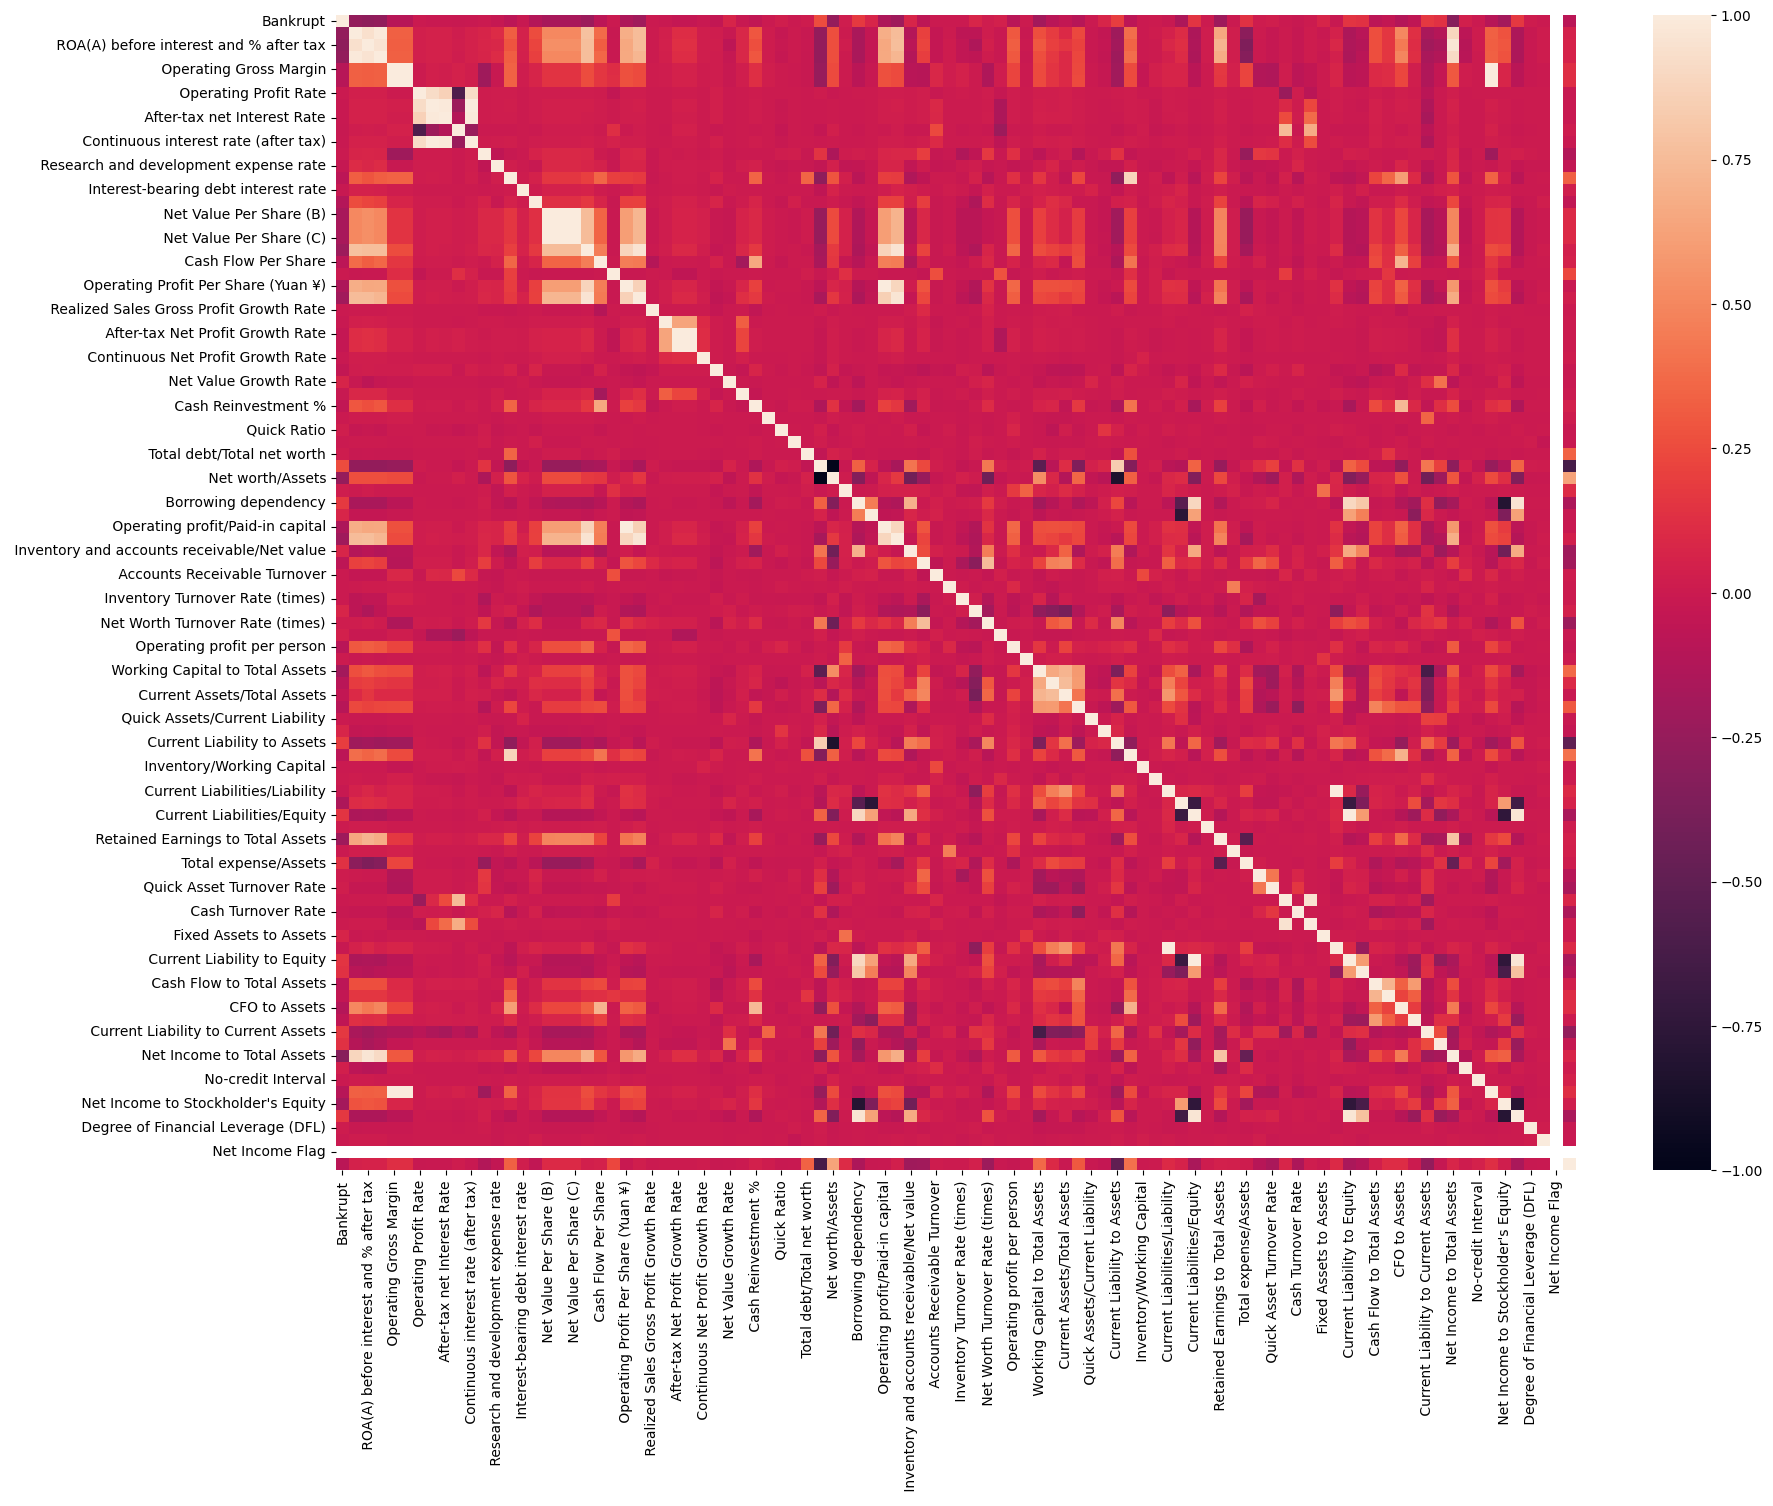

In [168]:
plt.subplots(figsize=(20,15))
sn.heatmap(df.corr())

<Axes: >

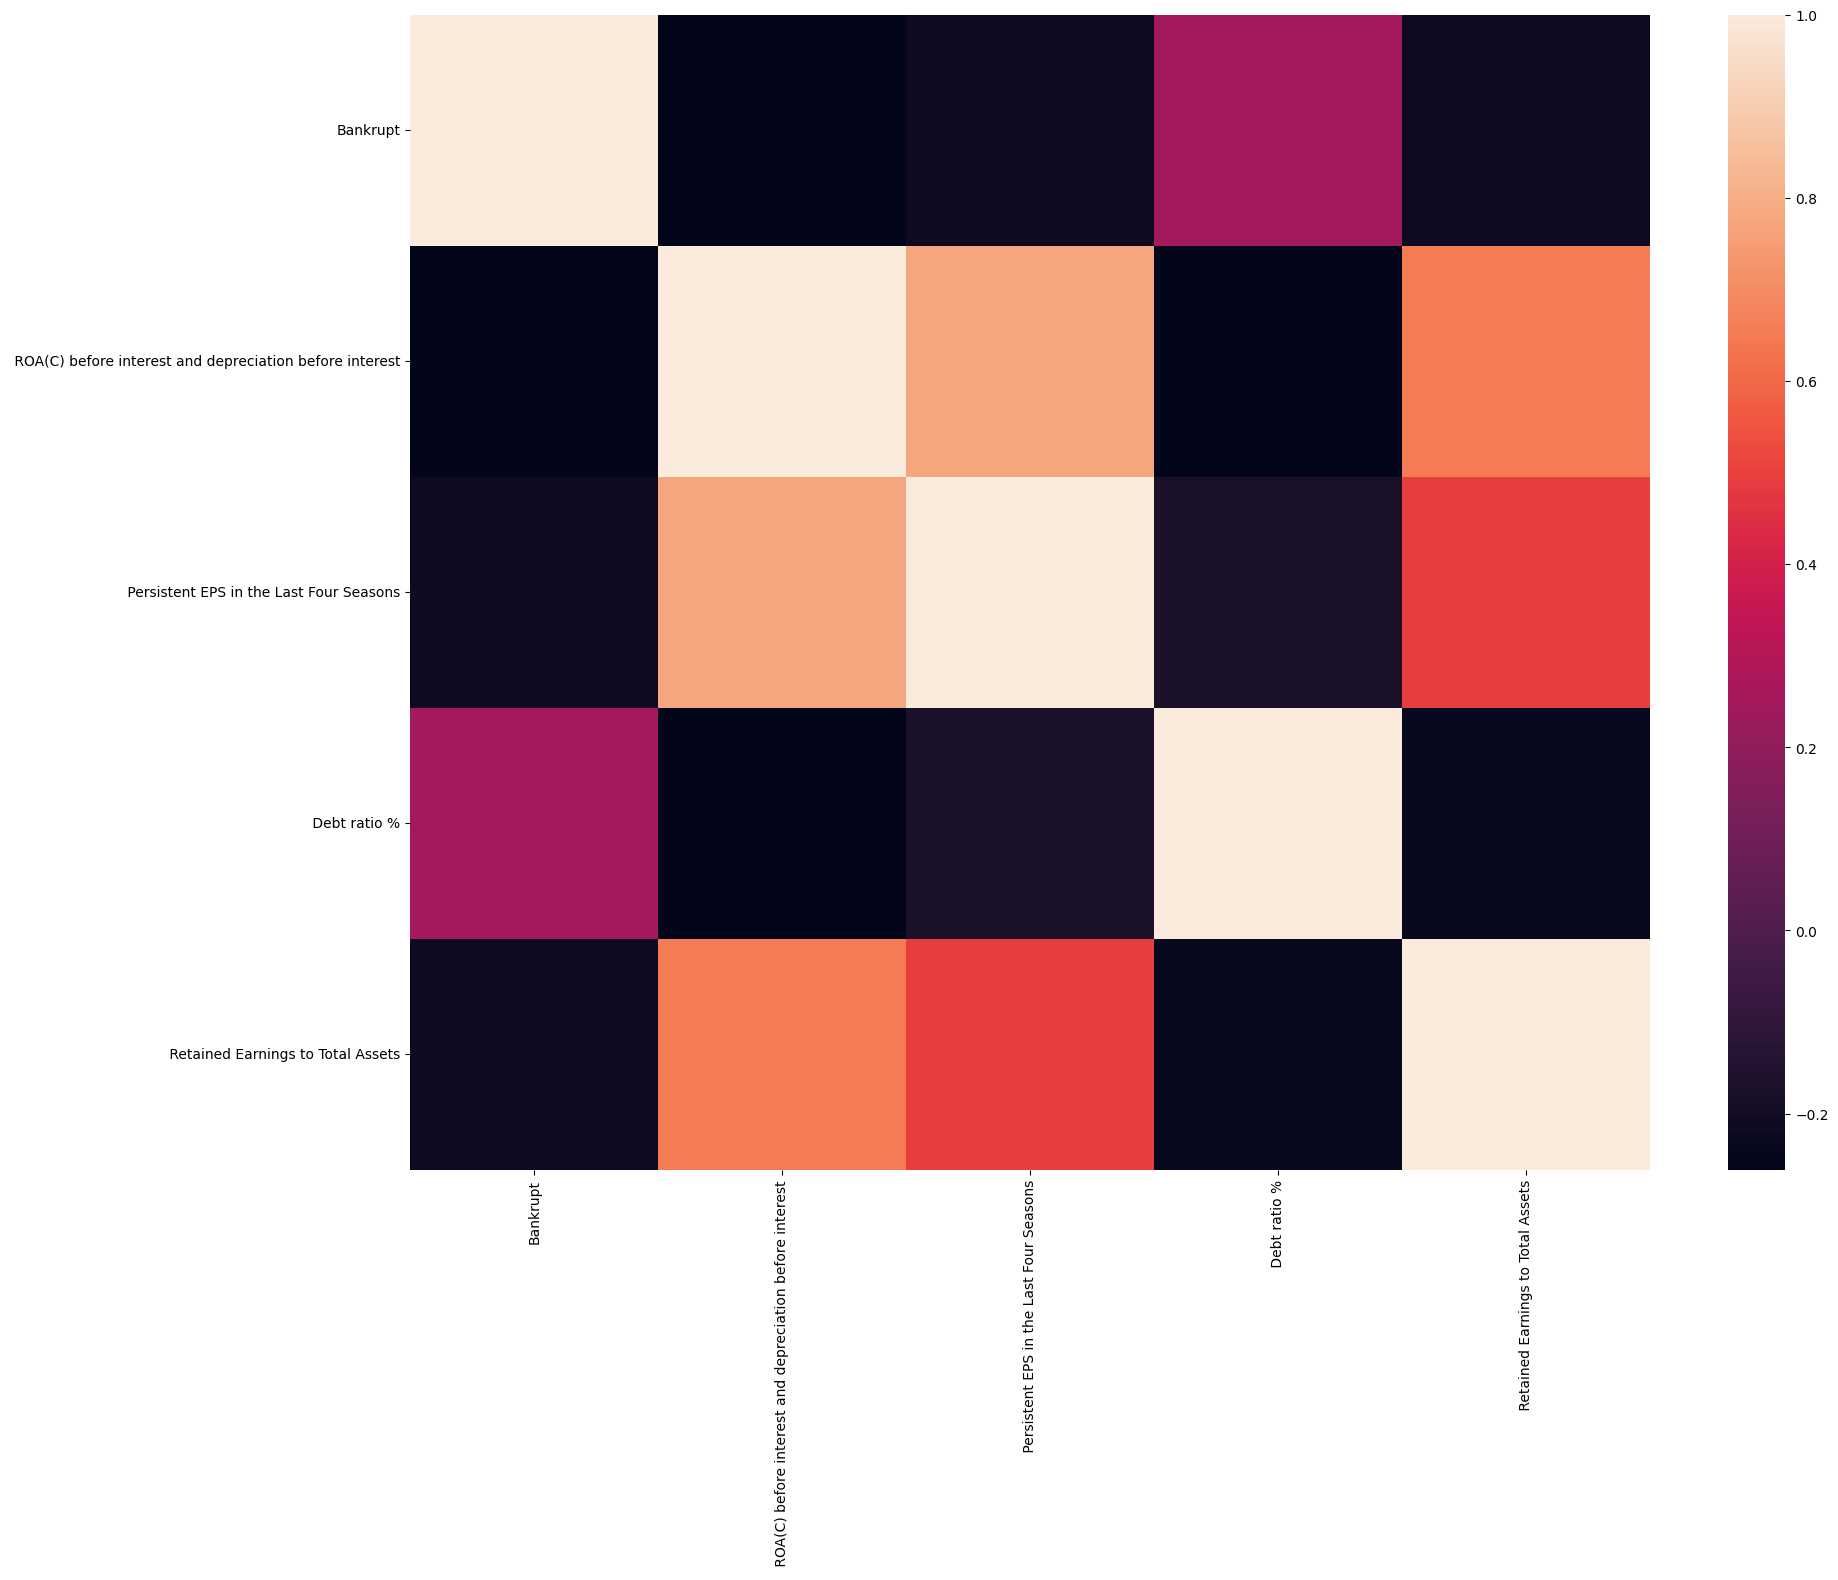

In [169]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Step 1: Identify columns where correlation with 'Bankrupt' is >= 0.25
columns_to_keep = correlation_matrix['Bankrupt'][abs(correlation_matrix['Bankrupt']) >= 0.20].index

# Step 2: Filter the dataset for the selected columns
df = df[columns_to_keep]

# Step 3: Remove highly correlated columns (correlation > 0.9)
correlation_matrix_filtered = df.corr()
columns_to_drop = set()

# Iterate through the correlation matrix to identify highly correlated columns
for i in range(len(correlation_matrix_filtered.columns)):
    for j in range(i + 1, len(correlation_matrix_filtered.columns)):
        if abs(correlation_matrix_filtered.iloc[i, j]) > 0.9:  # Threshold for high correlation
            col_to_drop = correlation_matrix_filtered.columns[j]
            columns_to_drop.add(col_to_drop)

# Drop the highly correlated columns
df = df.drop(columns=columns_to_drop)
plt.subplots(figsize=(20,15))
sn.heatmap(df.corr())

In [170]:
print(df['Bankrupt'].value_counts())

Bankrupt
0    6599
1     220
Name: count, dtype: int64


In [171]:


# Separate majority and minority classes
majority_class = df[df['Bankrupt'] == 0]
minority_class = df[df['Bankrupt'] == 1]

# Undersample the majority class to match the size of the minority class
majority_undersampled = resample(majority_class, 
                                 replace=False,    # Sample without replacement
                                 n_samples=len(minority_class),  # Match minority class size
                                 random_state=42)  # For reproducibility

# Combine undersampled majority class with the minority class
df_balanced = pd.concat([majority_undersampled, minority_class])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['Bankrupt'].value_counts())  # Check class balance

df = df_balanced


Bankrupt
1    220
0    220
Name: count, dtype: int64


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 5 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt                                                  440 non-null    int64  
 1    ROA(C) before interest and depreciation before interest  440 non-null    float64
 2    Persistent EPS in the Last Four Seasons                  440 non-null    float64
 3    Debt ratio %                                             440 non-null    float64
 4    Retained Earnings to Total Assets                        440 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 17.3 KB


In [173]:
df_Predictors=df.drop(["Bankrupt"],axis=1)
df_target=df.Bankrupt
features = df_Predictors
Xtrain,Xtest,ytrain,ytest=train_test_split(df_Predictors,df_target,random_state=10,test_size=0.2)
print("Shape of Xtrain:{} and Shape of ytrain:{} ".format(Xtrain.shape,ytrain.shape))
print("Shape of Xtest:{} and Shape of ytest:{} ".format(Xtest.shape,ytest.shape))

Shape of Xtrain:(352, 4) and Shape of ytrain:(352,) 
Shape of Xtest:(88, 4) and Shape of ytest:(88,) 


In [174]:
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import time

# Define classifier with class weights
classifiers = {
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state=42, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    #"LGBM" : LGBMClassifier(random_state=42)
}

# Define grid
KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

LR_grid = {'penalty': ['l1', 'l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

RF_grid = {'n_estimators': [50, 100, 150, 200],
           'max_depth': [4, 6, 8, 10, 12]}

LGBM_grid = {'n_estimators': [50, 100, 150],
             'max_depth': [4, 6, 8, 10, 12],
             'learning_rate': [0.05, 0.1, 0.15]}

grid = {
    "KNN": KNN_grid,
    "LogisticRegression": LR_grid,
    "RandomForest": RF_grid,
    "LGBM": LGBM_grid
}

# Initialize data structures
i = 0
clf_best_params = classifiers.copy()
scores = pd.DataFrame({
    'Classifier': classifiers.keys(),
    'Train F1 Score': np.zeros(len(classifiers)),
    'Validation F1 Score': np.zeros(len(classifiers)),
    'Training time (mins)': np.zeros(len(classifiers))
})

# Training loop with GridSearchCV
for key, classifier in classifiers.items():
    start = time.time()
    
    # Apply SMOTE for oversampling the minority class
    smote = SMOTE(sampling_strategy='minority')
    X_train_res, y_train_res = smote.fit_resample(Xtrain, ytrain)
    
    # GridSearchCV with parameter grid for each classifier
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)
    clf.fit(X_train_res, y_train_res)
    
    # Predict on train and validation sets
    ytrain_pred = clf.predict(X_train_res)
    ytest_pred = clf.predict(Xtest)
    
    # Calculate F1 scores
    train_f1 = f1_score(y_train_res, ytrain_pred)
    val_f1 = f1_score(ytest, ytest_pred)
    
    clf_best_params[key] = clf.best_params_
    
    stop = time.time()
    
    # Print model results
    print('Model:', key)
    print('Training time (mins):', scores.iloc[i, 3])
    print('Train F1 Score:', train_f1)
    print('Validation F1 Score:', val_f1)
    print('')
    
    i += 1

# Output best parameters and final scores
print(clf_best_params)

Model: KNN
Training time (mins): 0.0
Train F1 Score: 0.9030470914127424
Validation F1 Score: 0.7865168539325843

Model: LogisticRegression
Training time (mins): 0.0
Train F1 Score: 0.8539325842696629
Validation F1 Score: 0.8181818181818182

Model: RandomForest
Training time (mins): 0.0
Train F1 Score: 0.8969359331476323
Validation F1 Score: 0.8222222222222222

{'KNN': {'n_neighbors': 3, 'p': 2}, 'LogisticRegression': {'C': 1.25, 'max_iter': 50, 'penalty': 'l2'}, 'RandomForest': {'max_depth': 4, 'n_estimators': 50}}


In [175]:
train_features, test_features, train_labels, test_labels = train_test_split(
    df_Predictors, df_target, train_size=0.8)
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value
svc.fit(train_features, train_labels)

# Predict on train and validation sets
ytrain_pred = svc.predict(X_train_res)
ytest_pred = svc.predict(Xtest)
    
# Calculate F1 scores
train_f1 = f1_score(y_train_res, ytrain_pred)
val_f1 = f1_score(ytest, ytest_pred)

print(f"Classical SVC on the training dataset f1: {train_f1:.2f}")
print(f"Classical SVC on the test dataset f1:     {val_f1:.2f}")

Classical SVC on the training dataset f1: 0.86
Classical SVC on the test dataset f1:     0.83


In [176]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)
ansatz = RealAmplitudes(num_qubits=num_features, reps=5)
optimizer = COBYLA(maxiter=150)
sampler = Sampler()

In [177]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

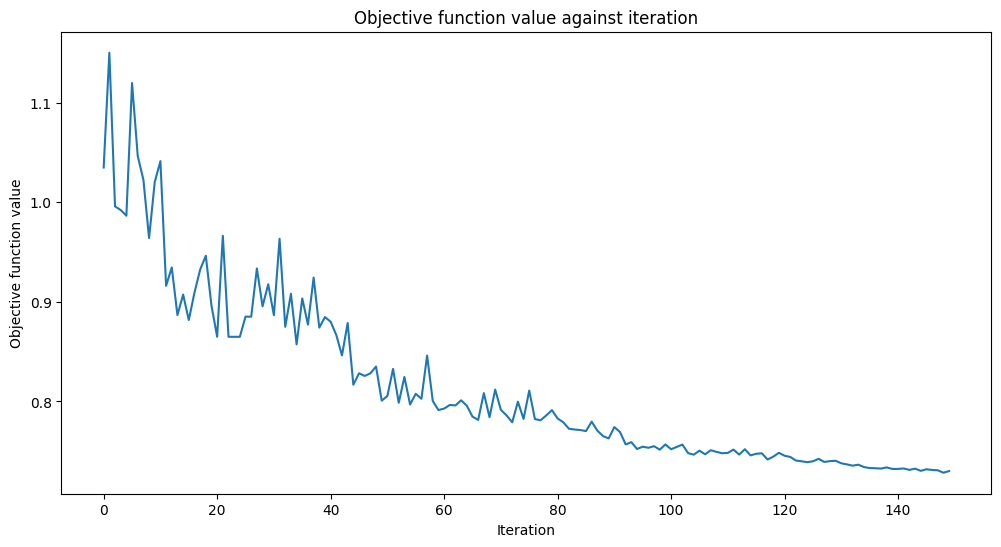

Training time: 100 seconds


In [178]:

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
train_labels = np.array(train_labels)
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [179]:
# Predict on train and validation sets
ytrain_pred = vqc.predict(X_train_res)
ytest_pred = vqc.predict(Xtest)
    
# Calculate F1 scores
train_f1 = f1_score(y_train_res, ytrain_pred)
val_f1 = f1_score(ytest, ytest_pred)

print(f"Classical QVC on the training dataset f1: {train_f1:.2f}")
print(f"Classical QVC on the test dataset f1:     {val_f1:.2f}")

Classical QVC on the training dataset f1: 0.84
Classical QVC on the test dataset f1:     0.80


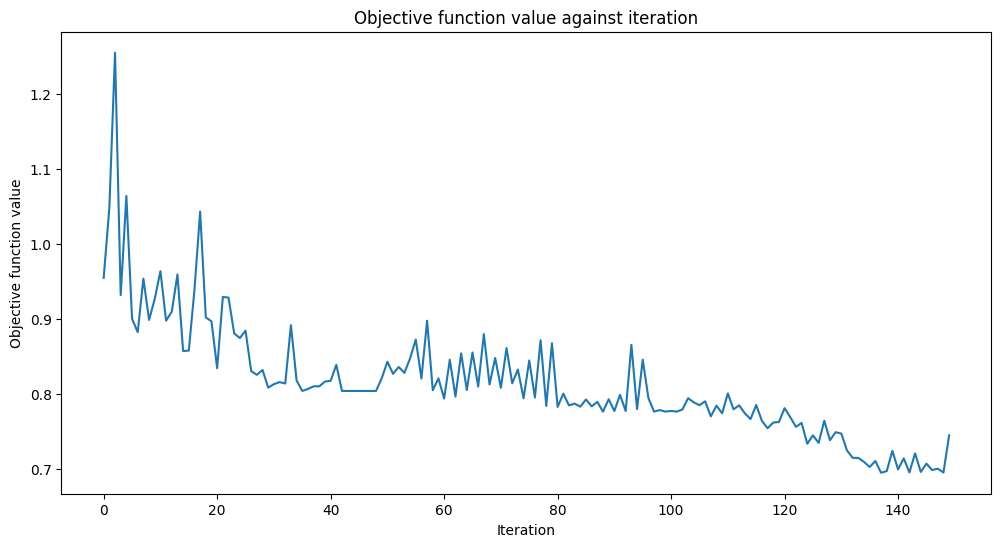

Training time: 137 seconds


In [180]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=5)
optimizer = COBYLA(maxiter=150)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [181]:
# Predict on train and validation sets
ytrain_pred = vqc.predict(X_train_res)
ytest_pred = vqc.predict(Xtest)
    
# Calculate F1 scores
train_f1 = f1_score(y_train_res, ytrain_pred)
val_f1 = f1_score(ytest, ytest_pred)

print(f"Classical QVC on the training dataset f1: {train_f1:.2f}")
print(f"Classical QVC on the test dataset f1:     {val_f1:.2f}")

Classical QVC on the training dataset f1: 0.86
Classical QVC on the test dataset f1:     0.84
